In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.feature import Normalizer, StandardScaler

import time

kafka_topic_name = "songTopic"
kafka_bootstrap_servers = 'localhost:9092'



In [2]:
spark = SparkSession \
        .builder \
        .appName("Spotify Streaming Reccomendation System") \
        .master("local[*]") \
        .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

    

In [3]:
# Construct a streaming DataFrame that reads from test-topic
songs_df = spark \
        .readStream \
        .format("kafka") \
        .option("kafka.bootstrap.servers", kafka_bootstrap_servers) \
        .option("subscribe", kafka_topic_name) \
        .option("startingOffsets", "latest") \
        .load()

print("Printing Schema of songs_df: ")

songs_df.printSchema()

    

Printing Schema of songs_df: 
root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



In [4]:
songs_df1 = songs_df.selectExpr("CAST(value AS STRING)", "timestamp")


songs_schema_string = "order_id INT,id STRING, name STRING,popularity INT, duration_ms DOUBLE, explicit INT, " \
                           + "artists STRING, id_artists STRING, release_date STRING, " \
                           + "danceability DOUBLE," \
                           + "energy DOUBLE, key INT, loudness DOUBLE, " \
                           + "mode INT," \
                           + "speechiness DOUBLE," \
                           + "acousticness DOUBLE, instrumentalness DOUBLE, liveness DOUBLE, " \
                           + "valence DOUBLE, tempo DOUBLE, time_signature DOUBLE"



songs_df2 = songs_df1 \
        .select(from_csv(col("value"), songs_schema_string) \
                .alias("song"), "timestamp")


songs_df3 = songs_df2.select("song.*", "timestamp")
songs_df3.printSchema()



root
 |-- order_id: integer (nullable = true)
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- popularity: integer (nullable = true)
 |-- duration_ms: double (nullable = true)
 |-- explicit: integer (nullable = true)
 |-- artists: string (nullable = true)
 |-- id_artists: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- danceability: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- key: integer (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: integer (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveness: double (nullable = true)
 |-- valence: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- time_signature: double (nullable = true)
 |-- timestamp: timestamp (nullable = true)



In [5]:
def simple():    
    songs_df3.createOrReplaceTempView("song_find");
    song_find_text = spark.sql("SELECT name, artists FROM song_find")
    songs_agg_write_stream = song_find_text \
            .writeStream \
            .trigger(processingTime='5 seconds') \
            .outputMode("update") \
            .option("truncate", "false") \
            .format("console") \
            .start()

    songs_agg_write_stream.awaitTermination()

    print("Songs Streaming...")
    
def csv_output():    
    song_find_text = spark.sql("SELECT name, artists FROM song_find")
    songs_agg_write_stream = song_find_text \
            .writeStream \
            .trigger(processingTime='5 seconds') \
            .outputMode("append") \
            .option("truncate", "false") \
            .option("path",'answ') \
            .option("checkpointLocation", "checkpoint_path") \
            .format("csv") \
            .start()

    songs_agg_write_stream.awaitTermination()

    print("Songs Streaming...")

In [6]:
songs_df3.createOrReplaceTempView("song_find");
song_find_text = spark.sql("SELECT * FROM song_find")
songs_agg_write_stream = song_find_text \
        .writeStream \
        .trigger(processingTime='5 seconds') \
        .outputMode("append") \
        .option("truncate", "false") \
        .format("memory") \
        .queryName("testedTable3") \
        .start()

songs_agg_write_stream.awaitTermination(1)

print("Songs Streaming...")

Songs Streaming...


In [71]:
df = spark.sql("SELECT * FROM testedTable3")

In [72]:
dfRDD = df.rdd

In [73]:
# getting the data from df.
df.show(3)

+--------+--------------------+--------------------+----------+-----------+--------+--------------+-------------------+------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+--------------------+
|order_id|                  id|                name|popularity|duration_ms|explicit|       artists|         id_artists|release_date|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|time_signature|           timestamp|
+--------+--------------------+--------------------+----------+-----------+--------+--------------+-------------------+------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+--------------------+
|      24|10XXG7gG75jIREUaM...|Capítulo 1.2 - Ba...|         0|   109500.0|       0|FernandoPessoa| jtPCOoNZwqukwdDxrY|  1922-06-01|       0.673| 0.239|  5| -22.552|   1|       0

In [74]:
df.columns

['order_id',
 'id',
 'name',
 'popularity',
 'duration_ms',
 'explicit',
 'artists',
 'id_artists',
 'release_date',
 'danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'time_signature',
 'timestamp']

In [75]:
df_count = df.count()
df_count

153

In [76]:
df.describe('popularity').show()

+-------+------------------+
|summary|        popularity|
+-------+------------------+
|  count|               152|
|   mean|3.6907894736842106|
| stddev| 8.588636842730766|
|    min|                 0|
|    max|                41|
+-------+------------------+



In [77]:
df.select('order_id','name','artists').show(10)

+--------+--------------------+---------------+
|order_id|                name|        artists|
+--------+--------------------+---------------+
|      24|Capítulo 1.2 - Ba...| FernandoPessoa|
|      25|  J'ai Vendu Mon Âme|   AdolpheBrard|
|      26|      Nuits De Chine|     LouisLynel|
|      27|En la Huella del ...| IgnacioCorsini|
|      28|C'est La Mode Et ...|      Perchicot|
|      29|Chapter 1.6 - Szk...|MariaKonopnicka|
|      30|    La Ronde De Nuit|      Perchicot|
|      31|El Patotero Senti...| IgnacioCorsini|
|      32|The Dear Little S...|     DickHaymes|
|      33|Tus Suspiros - Re...| IgnacioCorsini|
+--------+--------------------+---------------+
only showing top 10 rows



In [78]:
# getting the number of unique artists
df.select('artists').distinct().count()

31

In [79]:
# finding if there is any duplicate rows and deleting it.
dup_count = df.dropDuplicates().count()
dup_count = df_count - dup_count
dup_count

0

In [80]:
# get popular artists.
df.groupby('artists').agg({'popularity': 'mean'})
df.groupby('artists').count().orderBy('count', ascending=False).show()

+--------------------+-----+
|             artists|count|
+--------------------+-----+
|      FernandoPessoa|   42|
|      IgnacioCorsini|   34|
|         BessieSmith|   14|
|          DickHaymes|   12|
|     MariaKonopnicka|    7|
|                 Uli|    4|
|        AdolpheBrard|    3|
|BessieSmithLouisA...|    3|
|            Georgius|    3|
|           Perchicot|    2|
|KingOliversCreole...|    2|
|         Mistinguett|    2|
|      LouisArmstrong|    2|
|              Fortug|    2|
|DickHaymesHarryJa...|    2|
|LouisArmstrongHis...|    2|
|ClarenceWilliamsB...|    2|
|DickHaymesGordonJ...|    2|
|       VictorBoucher|    1|
|          LouisLynel|    1|
+--------------------+-----+
only showing top 20 rows



In [81]:
df.columns

['order_id',
 'id',
 'name',
 'popularity',
 'duration_ms',
 'explicit',
 'artists',
 'id_artists',
 'release_date',
 'danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'time_signature',
 'timestamp']

In [82]:
df = df.sort(df.release_date.desc())

In [83]:
from pyspark.ml.feature import VectorAssembler
assembler=VectorAssembler(inputCols=[
 'duration_ms',
 'explicit',
 'danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo'], outputCol='features')
assembled_data=assembler.setHandleInvalid("skip").transform(df)
assembled_data.show(2)

+--------+--------------------+--------------------+----------+-----------+--------+--------------------+--------------------+------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+--------------------+--------------------+
|order_id|                  id|                name|popularity|duration_ms|explicit|             artists|          id_artists|release_date|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|time_signature|           timestamp|            features|
+--------+--------------------+--------------------+----------+-----------+--------+--------------------+--------------------+------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+--------------------+--------------------+
|     149|2wAfHM7Whz67VFbda...|Nobody Knows You ...|        41|   177133.0|       0|         B

In [84]:
from pyspark.ml.feature import StandardScaler
scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(assembled_data)
df=data_scale.transform(assembled_data)
df.show(2)

+--------+--------------------+--------------------+----------+-----------+--------+--------------------+--------------------+------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+--------------------+--------------------+--------------------+
|order_id|                  id|                name|popularity|duration_ms|explicit|             artists|          id_artists|release_date|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|time_signature|           timestamp|            features|        standardized|
+--------+--------------------+--------------------+----------+-----------+--------+--------------------+--------------------+------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+--------------------+--------------------+--------------------+
|     149|2wAfHM7Whz67VFbda...|

In [51]:
df.show(3)

+--------+--------------------+--------------------+----------+-----------+--------+--------------+-------------------+-------------------+------------+------+----+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+--------------------+
|order_id|                  id|                name|popularity|duration_ms|explicit|       artists|         id_artists|       release_date|danceability|energy| key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|time_signature|           timestamp|
+--------+--------------------+--------------------+----------+-----------+--------+--------------+-------------------+-------------------+------------+------+----+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+--------------------+
|     153|6XTvSCqGLLH0vzQQR...|     Empty Bed Blues|      null|       27.0|  181173|             0|        BessieSmith|ESobCkcJItIMxQttqeg|      1923.0| 0

In [85]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,10):
    
    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    
    KMeans_fit=KMeans_algo.fit(df)
    
    output=KMeans_fit.transform(df)
    
    
    
    score=evaluator.evaluate(output)
    
    silhouette_score.append(score)
    
    print("Silhouette Score:",score)

Silhouette Score: 0.39809572767779416
Silhouette Score: 0.3609279301864996
Silhouette Score: 0.3908633535208746
Silhouette Score: 0.3399400685007238
Silhouette Score: 0.33963130880739584
Silhouette Score: 0.3693245551784773
Silhouette Score: 0.3406402022810879
Silhouette Score: 0.29151381255853226


Text(0, 0.5, 'cost')

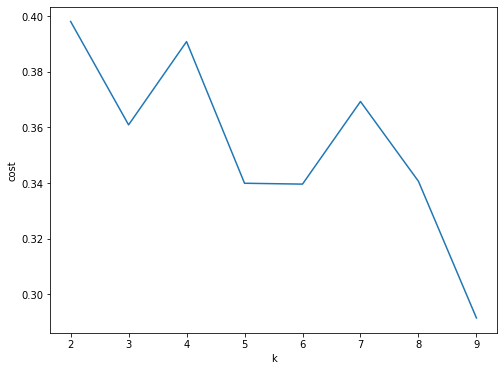

In [87]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score)
ax.set_xlabel("k")
ax.set_ylabel("cost")